In [22]:
# Importing libraries for data manipulation
import sqlite3
import pandas as pd

# Importing libraries for data visualization
import matplotlib.pyplot as plt
import numpy as np

# Importing libraries for data preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Importing libraries for classification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report

# Importing libraries for classification models
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import GridSearchCV

from py_helpers.pipeline_helper import *
from py_helpers.db_helper import *



In [23]:
df_all = retrieve_data('./db/WNBA_filtered.db', 'merged')
df_shift = retrieve_data('./db/WNBA_filtered.db', 'merged_shift')

df = df_shift

In [24]:

# Create list with all unique values of the team names
team_names = df['tmID'].unique().tolist()
print(team_names)

# label_encoder = LabelEncoder()
# df['tmID'] = label_encoder.fit_transform(df['tmID'])
# df = df.drop(['tmID'], axis=1)

# Shuffling the DataFrame
# df = df.sample(frac=1, random_state=42) 



['CHA', 'CLE', 'DET', 'HOU', 'IND', 'LAS', 'MIA', 'MIN', 'NYL', 'ORL', 'PHO', 'POR', 'SAC', 'SEA', 'UTA', 'WAS', 'CON', 'SAS', 'CHI', 'ATL', 'TUL']


In [25]:
len(team_names)
encoder = LabelEncoder()
team_names = encoder.fit_transform(team_names)
print(team_names)

[ 1  3  5  6  7  8  9 10 11 12 13 14 15 17 19 20  4 16  2  0 18]


In [26]:
class_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
print("Class - Label Mapping:")
for class_label, encoded_value in class_mapping.items():
    print(f"{class_label}: {encoded_value}")

Class - Label Mapping:
ATL: 0
CHA: 1
CHI: 2
CLE: 3
CON: 4
DET: 5
HOU: 6
IND: 7
LAS: 8
MIA: 9
MIN: 10
NYL: 11
ORL: 12
PHO: 13
POR: 14
SAC: 15
SAS: 16
SEA: 17
TUL: 18
UTA: 19
WAS: 20


In [27]:
# Encoding the df using the encoder
df['tmID'] = encoder.transform(df['tmID'])


In [28]:
df.loc[df['tmID'] == 18]

,tmID,year,playoff,principal_component_1,principal_component_2,GP,GS,minutes,points,oRebounds,...,height,weight,birthYear,pos_C,pos_C_F,pos_F,pos_F_C,pos_F_G,pos_G,pos_G_F
2327,18,11,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,75.0,167,1988.0,0,0,1,0,0,0,0
2328,18,11,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,75.0,167,1988.0,0,0,1,0,0,0,0
2329,18,11,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,80.0,215,1991.0,1,0,0,0,0,0,0
2330,18,11,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,80.0,215,1991.0,1,0,0,0,0,0,0
2331,18,11,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,72.0,180,1989.0,0,0,1,0,0,0,0
2332,18,11,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,72.0,180,1989.0,0,0,1,0,0,0,0
2333,18,11,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,69.0,160,1982.0,0,0,0,0,0,1,0
2334,18,11,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,69.0,160,1982.0,0,0,0,0,0,1,0
2335,18,11,NaN,0.0,0.0,23.0,7.0,380.0,137.0,13.0,...,72.0,168,1985.0,0,0,1,0,0,0,0
2336,18,11,NaN,0.0,0.0,23.0,7.0,380.0,137.0,13.0,...,72.0,168,1985.0,0,0,1,0,0,0,0


In [29]:
# Metrics to be used for evaluation of the model performance
metrics =  {
    'accuracy' : accuracy_score    # Accuracy -> bad with unbalanced data
    # 'precision' : precision_score,  # Precision -> good with unbalanced data (high precision means low false positives)
    # 'recall' : recall_score,        # Recall -> good with unbalanced data (high recall means low false negatives)
    # 'f1' : f1_score,                # F1 -> good with unbalanced data (high f1 means low false positives and false negatives)
    # 'roc_auc' : roc_auc_score       # ROC AUC -> good with unbalanced data (high roc auc means low false positives and false negatives)
}

In [30]:
target = 'playoff'  # The target attribute
seed = 42           # The random seed for the train-test split
testing = False

In [31]:
# Define the pipeline with different models

# Logistic Regression Pipeline Model (model_lr)
model_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=seed))
])

# Random Forest Pipeline Model (model_rf)
model_rf = Pipeline([
    #('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=seed))
])

# Support Vector Machine Pipeline Model (model_svm)
model_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC(random_state=seed))
])

# Gradient Boosting Machine Pipeline Model (model_gb)
model_gb = Pipeline([
    #('scaler', StandardScaler()),
    ('classifier', GradientBoostingClassifier(random_state=seed))
])

# Neural Network Pipeline Model (model_nn)
model_nn = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', MLPClassifier(random_state=seed))
])

# Dictionary of all the models
all_models =  { 'Logistic Regression' : model_lr, 
                'Random Forest' : model_rf, 
                'Support Vector Machine' : model_svm, 
                'Gradient Boosting' : model_gb, 
                'Neural Network' : model_nn
              }

In [32]:
all_results = { 'sliding': [], 'expanding': [] , 'mixed' : []}

In [33]:
# Sliding window analysis
total_years = 10 # Total number of years that we have data for
window_size = 4 # Maybe test with different window sizes

start = 5

all_results['sliding'] = {}
for model_name, model in all_models.items():
    all_results['sliding'][model_name] = sliding_window_analysis(df, start, total_years, window_size, target, metrics, model)

plot_metrics_for_models(all_results['sliding'], all_models, start, total_years, metrics)

KeyboardInterrupt: 

C:\Users\janto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\janto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\janto\AppData\Local\Packages\PythonSoftwareFoundation

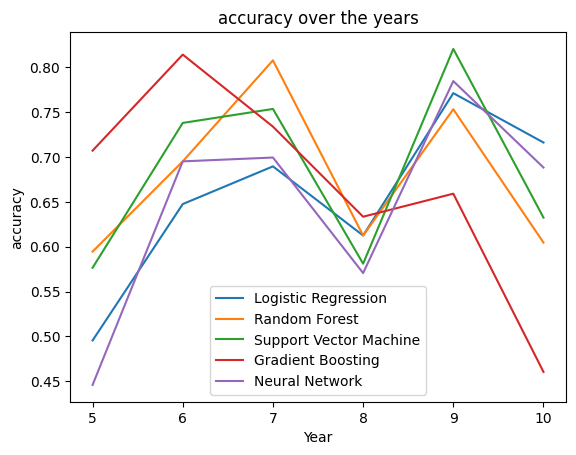

In [ ]:
# Expanding window analysis
total_years = 10  # Total number of years that we have data for
start = 5 # Should be higher than 1 because we need to have at least 1 year of training data

all_results['expanding'] = {}
for model_name, model in all_models.items():
    all_results['expanding'][model_name] = expanding_window_analysis(df, start, total_years, target, metrics, model)

plot_metrics_for_models(all_results['expanding'], all_models, start, total_years, metrics)

C:\Users\janto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\janto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\janto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\janto\A

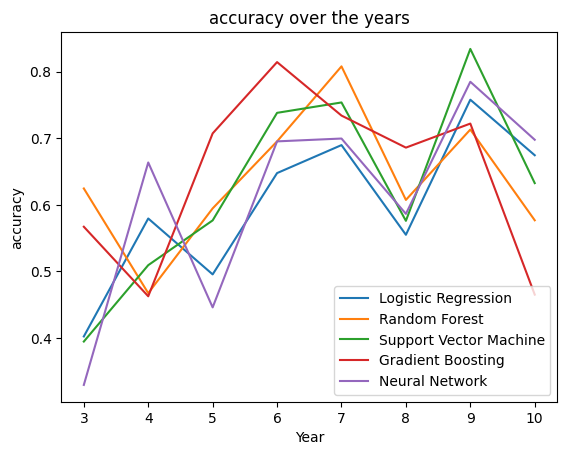

In [ ]:
# Mixed window analysis
total_years = 10  # Total number of years that we have data for
start = 3  # Should be higher than 1 because we need to have at least 1 year of training data
start_sliding = 6  # Decide when to start sliding when predicting the 6th year

all_results['mixed'] = {}
for model_name, model in all_models.items():
    all_results['mixed'][model_name] = mixed_window_analysis(df, total_years, start, start_sliding, metrics, model, target)

plot_metrics_for_models(all_results['mixed'], all_models, start, total_years, metrics)

In [ ]:
# Logistic Regression Pipeline Model (model_lr)
model_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=seed))
])

# Random Forest Pipeline Model (model_rf)
model_rf = Pipeline([
    #('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=seed))
])

# Support Vector Machine Pipeline Model (model_svm)
model_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC(random_state=seed))
])

# Gradient Boosting Machine Pipeline Model (model_gb)
model_gb = Pipeline([
    #('scaler', StandardScaler()),
    ('classifier', GradientBoostingClassifier(random_state=seed))
])

# Neural Network Pipeline Model (model_nn)
model_nn = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', MLPClassifier(max_iter=500, random_state=seed))  # Increase max_iter
])

tuned_models =  { 'Logistic Regression' : model_lr,
                'Random Forest' : model_rf, 
                'Support Vector Machine' : model_svm, 
                'Gradient Boosting' : model_gb, 
                'Neural Network' : model_nn
              }

In [ ]:
# Hyperparameter grids for each model
param_grid_lr = {
    'classifier__penalty': ['l2'],  # Only 'l2' penalty with lbfgs solver
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]  
}

param_grid_rf = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}


param_grid_svm = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__kernel': ['linear', 'rbf', 'poly'],
    'classifier__gamma': ['scale', 'auto']
}

param_grid_gb = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 5, 7],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

param_grid_nn = {
    'classifier__hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'classifier__activation': ['relu', 'logistic'],
    'classifier__alpha': [0.0001, 0.001, 0.01],
    'classifier__learning_rate': ['constant', 'adaptive']
}

param_grids = {
    'Logistic Regression': param_grid_lr,
    'Random Forest': param_grid_rf,
    'Support Vector Machine': param_grid_svm,
    'Gradient Boosting': param_grid_gb,
    'Neural Network': param_grid_nn
}

In [ ]:
def tune_and_evaluate_model(model_name, pipeline, param_grid, df, start, total_years, window_size, target, window_type='sliding'):
    # Extract metrics for the specified model
    metrics = {'accuracy': accuracy_score}

    # Perform grid search using cross-validation
    grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    
    # Perform sliding window analysis and store results
    if (window_type == 'sliding'):
        results = sliding_window_analysis(df, start, total_years, window_size, target, metrics, grid_search)
    elif (window_type == 'expanding'):
        results = expanding_window_analysis(df, start, total_years, target, metrics, grid_search)
    elif (window_type == 'mixed'):
        results = mixed_window_analysis(df, total_years, start, start_sliding, metrics, grid_search, target)

    # Output the best parameters from the grid search
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")

    # Output the mean and standard deviation of accuracy across all windows
    mean_accuracy = np.mean(results['accuracy'])
    std_accuracy = np.std(results['accuracy'])
    print(f"Mean accuracy: {mean_accuracy:.4f}, Standard deviation: {std_accuracy:.4f}")


    return results


In [ ]:
start = 5
window_size = 4

all_results = {}
# Iterate through each model and perform tuning and evaluation
for model_name, pipeline in tuned_models.items():
    param_grid = param_grids[model_name]
    all_results[model_name] = tune_and_evaluate_model(model_name, pipeline, param_grid, df, start, total_years, window_size, target, window_type='sliding')
    
plot_metrics_for_models(all_results, tuned_models, start, total_years, metrics)


Best parameters for Logistic Regression: {'classifier__C': 1, 'classifier__penalty': 'l2'}
Mean accuracy: 0.6364, Standard deviation: 0.0571
Best parameters for Random Forest: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 50}
Mean accuracy: 0.6488, Standard deviation: 0.0663
Best parameters for Support Vector Machine: {'classifier__C': 1, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear'}
Mean accuracy: 0.6686, Standard deviation: 0.0570


KeyboardInterrupt: 

C:\Users\janto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best parameters for Logistic Regression: {'classifier__C': 0.01, 'classifier__penalty': 'l2'}
Mean accuracy: 0.8768, Standard deviation: 0.0319
Best parameters for Random Forest: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 100}
Mean accuracy: 0.9111, Standard deviation: 0.0116
Best parameters for Support Vector Machine: {'classifier__C': 0.001, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear'}
Mean accuracy: 0.8651, Standard deviation: 0.0433
Best parameters for Gradient Boosting: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 50}
Mean accuracy: 0.7702, Standard deviation: 0.1501


C:\Users\janto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\janto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters for Neural Network: {'classifier__activation': 'logistic', 'classifier__alpha': 0.01, 'classifier__hidden_layer_sizes': (100,), 'classifier__learning_rate': 'constant'}
Mean accuracy: 0.8810, Standard deviation: 0.0491


C:\Users\janto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


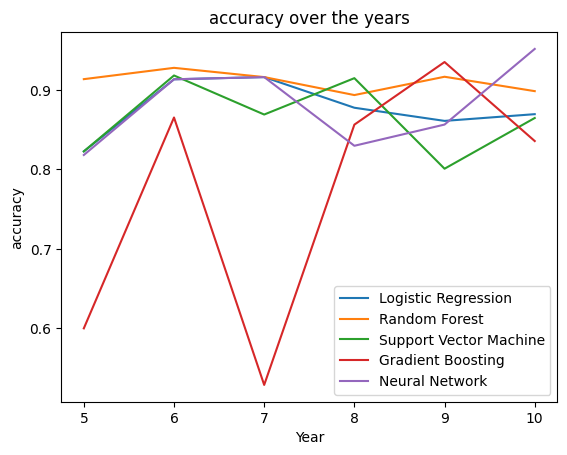

In [ ]:
start = 5
window_size = 4

all_results = {}
# Iterate through each model and perform tuning and evaluation
for model_name, pipeline in tuned_models.items():
    param_grid = param_grids[model_name]
    all_results[model_name] = tune_and_evaluate_model(model_name, pipeline, param_grid, df, start, total_years, window_size, target, window_type='expanding')
    
plot_metrics_for_models(all_results, tuned_models, start, total_years, metrics)


C:\Users\janto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\janto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab

Best parameters for Logistic Regression: {'classifier__C': 0.1, 'classifier__penalty': 'l2'}
Mean accuracy: 0.8870, Standard deviation: 0.0424
Best parameters for Random Forest: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 50}
Mean accuracy: 0.8914, Standard deviation: 0.0309
Best parameters for Support Vector Machine: {'classifier__C': 0.1, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear'}
Mean accuracy: 0.8682, Standard deviation: 0.0673
Best parameters for Gradient Boosting: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Mean accuracy: 0.7474, Standard deviation: 0.1352


C:\Users\janto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\janto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\janto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters for Neural Network: {'classifier__activation': 'relu', 'classifier__alpha': 0.01, 'classifier__hidden_layer_sizes': (100,), 'classifier__learning_rate': 'constant'}
Mean accuracy: 0.8553, Standard deviation: 0.0685


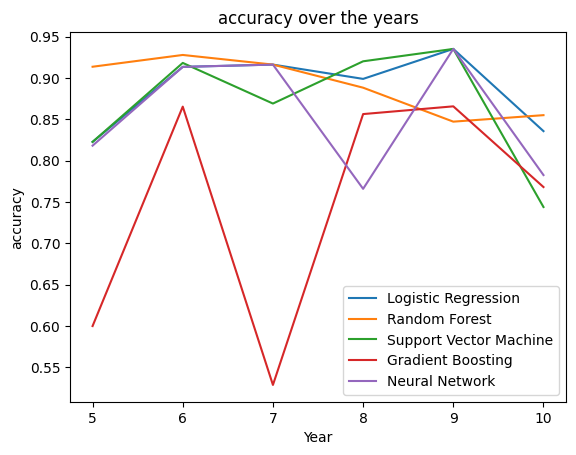

In [ ]:
start = 5
window_size = 4

all_results = {}
# Iterate through each model and perform tuning and evaluation
for model_name, pipeline in tuned_models.items():
    param_grid = param_grids[model_name]
    all_results[model_name] = tune_and_evaluate_model(model_name, pipeline, param_grid, df, start, total_years, window_size, target, window_type='mixed')
    
plot_metrics_for_models(all_results, tuned_models, start, total_years, metrics)


In [58]:
predictions = {}
window_size = 3
start = 6
end = 10

models_to_run = [
    'Logistic Regression'
    #'Random Forest',
    #'Support Vector Machine',
    #'Neural Network'
]



for model_name, pipeline in tuned_models.items():

    results_per_year = {}

    if (model_name not in models_to_run):
        continue

    model_results = {} # Year -> [Data, Result, Predictions]
    w_size = 0
    for year in range(start, end + 1):
        # if side less than window size, expand window
        if (w_size < window_size):
            w_size += 1

        df_train = df[(df['year'] <= year - 1) & (df['year'] >= year - w_size)]
        df_test = df[df['year'] == year]

        X_train = df_train.drop(['playoff'], axis=1)
        y_train = df_train['playoff']

        if (year != 11):
            X_test = df_test.drop(['playoff'], axis=1)
            y_test = df_test['playoff']
        else:
            X_test = df_test
            y_test = None

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)


        #result_df = pd.concat([X_test, pd.Series(y_test, name='y_real'), pd.Series(y_pred, name='y_pred')])

        # concatenate all the info in X_test, y_test, y_pred
        result_df = X_test.copy()
        result_df['y_real'] = y_test
        result_df['y_pred'] = y_pred

        # retriebe the tmID from the label encoder
        result_df['tmID'] = encoder.inverse_transform(result_df['tmID'])
        results_per_year[year] = result_df.groupby(['tmID', 'year']).agg({'y_pred': 'median', 'y_real': 'median'}).reset_index()

    
    # for each yerar in the results_per_year
    # do a table withe the teams and the predictions

    table_df = pd.DataFrame()

    for year, result_df in results_per_year.items():
        
        # Create a column prefix for each year
        col_prefix = f'y_{year}'

        # Rename the columns to include the year
        result_df = result_df.rename(columns={'y_real': f'{year}_real', 'y_pred': f'{year}_pred'})

        # Convert the float values in the 'y_pred' and 'y_real' columns to integers

        # round(players_df[players_df['pos'].isin(['C'])]['height'], 1)
    
        result_df[f'{year}_real'] = round(result_df[f'{year}_real'], 0).astype(bool).astype(int)
        result_df[f'{year}_pred'] = round(result_df[f'{year}_pred'], 0).astype(bool).astype(int)
        
        # Drop the 'year' column as it's already represented in the column names
        result_df = result_df.drop('year', axis=1)

        if table_df.empty:
            # If it's the first iteration, directly assign the result_df to table_df
            table_df = result_df
        else:
            # If not the first iteration, merge on 'tmID'
            table_df = pd.merge(table_df, result_df, on='tmID', how='outer')

    # Sort the DataFrame by 'tmID' for better readability
    table_df = table_df.sort_values(by='tmID').reset_index(drop=True)

year = 11
for model_name, pipeline in tuned_models.items():
    results_year_11 = pd.DataFrame()
    if (model_name not in models_to_run):
        continue

    df_train = df[(df['year'] <= year - 1) & (df['year'] >= year - w_size)]
    df_test = df[df['year'] == year]


    X_train = df_train.drop(['playoff'], axis=1)
    y_train = df_train['playoff']


    X_test = df_test.drop(['playoff'], axis=1) 
    y_test = None


    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    results_year_11 = X_test.copy()
    results_year_11['y_pred'] = y_pred 

    results_year_11['tmID'] = encoder.inverse_transform(results_year_11['tmID'])
    results_year_11 = results_year_11.groupby(['tmID']).agg({'y_pred': 'median'}).reset_index()

    table_df = pd.merge(table_df, results_year_11, on='tmID', how='outer')
    
table_df.head(20)



,tmID,6_pred,6_real,7_pred,7_real,8_pred,8_real,9_pred,9_real,10_pred,10_real,y_pred
0,ATL,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.0
1,CHA,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CHI,NaN,NaN,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,CON,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
4,DET,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,NaN
5,HOU,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN
6,IND,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
7,LAS,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
8,MIN,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
9,NYL,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0
